In [1]:
import numpy as np
import pandas as pd
import random
import ast

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from torchvision import models, transforms
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

from labml.logger import inspect
from labml_nn.transformers.mha import MultiHeadAttention
from labml_nn.transformers.rope import RotaryPositionalEmbeddings

from scipy.linalg import svd

from minisom import MiniSom

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

###### old

In [2]:
data = np.load('../../data/raw/32/birdclef2025_melspec_5sec_32_32.npy',allow_pickle=True)
debug_dict = data.item()
labels = pd.read_csv('../../data/raw/birdclef-2025/taxonomy.csv')
train = pd.read_csv("../../data/raw/birdclef-2025/train.csv")
split_df = pd.read_csv("../../data/preprocessed/work_df_w_split_info.csv")  # assuming this contains the split info

In [4]:
split_df

,primary_label,rating,filename,target,filepath,samplename,class,y_species_encoded,split
0,1139490,0.0,1139490/CSA36385.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36385,Insecta,2,test
1,1139490,0.0,1139490/CSA36389.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36389,Insecta,2,train
2,1192948,0.0,1192948/CSA36358.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36358,Insecta,2,train
3,1192948,0.0,1192948/CSA36366.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36366,Insecta,2,train
4,1192948,0.0,1192948/CSA36373.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36373,Insecta,2,val
...,...,...,...,...,...,...,...,...,...
28559,ywcpar,0.0,ywcpar/iNat77392.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat77392,Aves,1,val
28560,ywcpar,0.0,ywcpar/iNat78624.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat78624,Aves,1,train
28561,ywcpar,0.0,ywcpar/iNat789234.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat789234,Aves,1,train
28562,ywcpar,0.0,ywcpar/iNat819873.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat819873,Aves,1,train


In [5]:
train

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0


In [7]:
# Drop redundant columns from split_df before merging
cols_to_drop = ['primary_label', 'filename', 'rating']
split_df_clean = split_df.drop(columns=[col for col in cols_to_drop if col in split_df.columns])

# Now merge safely
merged_df = train.merge(split_df_clean, left_index=True, right_index=True)

In [8]:
merged_df

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,target,filepath,samplename,class,y_species_encoded,split
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36385,Insecta,2,test
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36389,Insecta,2,train
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36358,Insecta,2,train
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36366,Insecta,2,train
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36373,Insecta,2,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat77392,Aves,1,val
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat78624,Aves,1,train
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat789234,Aves,1,train
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat819873,Aves,1,train


In [ ]:
id_to_class = dict(zip(labels['primary_label'].astype(str), labels['class_name']))

X = []
y = []

for key, img in debug_dict.items():
    id_part = key.split('-')[0]
    class_name = id_to_class.get(id_part)
    if class_name:
        X.append(img)
        y.append(class_name)

X = np.array(X)
y = np.array(y)

In [ ]:
# Flatten the images
n_samples, h, w = X.shape
X_flat = X.reshape(n_samples, h * w)

# Encode string labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

###### new

In [ ]:
# Convert to NumPy and flatten images
def to_flat_array(X_list):
    X_arr = np.array(X_list)
    n_samples, h, w = X_arr.shape
    return X_arr.reshape(n_samples, h * w)

In [ ]:
# Load data
data = np.load('../../data/raw/32/birdclef2025_melspec_5sec_32_32.npy', allow_pickle=True)
debug_dict = data.item()

# Load labels and splits
labels = pd.read_csv('../../data/raw/birdclef-2025/taxonomy.csv')
train_meta = pd.read_csv("../../data/raw/birdclef-2025/train.csv")  # Might be useful later
split_df = pd.read_csv("../../data/preprocessed/work_df_w_split_info.csv")  # assuming this contains the split info

# Build lookup table from split CSV
split_info = split_df.set_index('samplename')[['split', 'y_species_encoded']].to_dict('index')

# Prepare data containers
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

# Iterate over debug_dict and route based on split info
for key, img in debug_dict.items():
    info = split_info.get(key)
    if info:
        split = info['split']
        label = info['y_species_encoded']
        if split == 'train':
            X_train.append(img)
            y_train.append(label)
        elif split == 'val':
            X_val.append(img)
            y_val.append(label)
        elif split == 'test':
            X_test.append(img)
            y_test.append(label)

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
X_train = to_flat_array(X_train)
X_val = to_flat_array(X_val)
X_test = to_flat_array(X_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
np.ma.shape(X_train)

In [ ]:
pca = PCA(n_components=92, random_state=42)  # tune n_components
X_pca = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

In [ ]:
np.ma.shape(X_pca)

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_flat, y_resampled = smote.fit_resample(X_pca, y_train)

# Update training data
X_train, y_train = X_resampled_flat, y_resampled

In [ ]:
np.ma.shape(X_train)

#### Decision Tree from Metadata
adapting WooJung's code from raw_data_EDA.ipynb

In [40]:
### WOOJUNG CODE ###

# mapping primary - scientific - common labels
mapped = merged_df[["primary_label", "scientific_name", "common_name"]]

mapped = mapped.drop_duplicates()
mapped.index = range(len(mapped))

spec_dat = labels.drop("inat_taxon_id", axis = 1)
# we have class name for each primary label

# merging class_name
full_data = pd.merge(merged_df, spec_dat, on = ["primary_label", "scientific_name", "common_name"], how = "left")
full_data.head()

full_data = full_data.replace(to_replace=r"\[''\]", value=pd.NA, regex=True)

# song/canto call/whistle/chamado; uncertain/?/no idea/aberrant; sound/noise/sonido/wing/drum/rattle; flight call; alarm call/alarm;
sound_categories = {
    "song/canto": {"song", "duet", "canto"},
    "call": {"call", "llamado"},
    "uncertain": {"uncertain", "?", "no idea", "aberrant"},
    "mating/groups": {"lek", "communal"},
    "hatching": {"hatch"},
    "immitation": {"immitation", "mimic"},
    "noise/drum": {"drumming", "rattle", "noise", "wing", "sound", "sonido", "tamborilar", "human", "dog", "cow", "frog"}
}

print(full_data['class_name'].value_counts())

# Select minimal columns (don't drop rows yet)
sound = full_data[["primary_label", "scientific_name", "common_name","type", "class_name", "longitude", "latitude", "class","y_species_encoded","split",'filename']].copy()

# Now drop rows where 'type' is missing
sound = sound[sound["longitude"].notna()].copy()
sound = sound[sound["latitude"].notna()].copy()
sound = sound[sound["latitude"].notna()].copy()

# Downsample first: keep up to 100 per class
sound = sound.groupby("class_name", group_keys=False).apply(
    lambda x: x.sample(n=min(100, len(x)), random_state=42)
).reset_index(drop=True)

print(sound['class_name'].value_counts())

# Parse type list
sound["type_list"] = sound["type"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])

# Clean and flag uncertain labels
def parse_label(label):
    label = label.strip().lower()
    if label.endswith("?"):
        return label[:-1].strip(), True
    return label, False

def parse_labels_list(label_list):
    parsed = [parse_label(lbl) for lbl in label_list]
    clean_labels = [lbl for lbl, _ in parsed]
    is_uncertain = any(flag for _, flag in parsed)
    return clean_labels, is_uncertain

sound[["clean_labels", "has_uncertain"]] = sound["type_list"].apply(
    lambda labels: pd.Series(parse_labels_list(labels))
)

# Assign categories
def assign_categories(label_str, category_dict):
    label = label_str.lower()
    matched_categories = []
    for category, keywords in category_dict.items():
        if any(keyword in label for keyword in keywords):
            matched_categories.append(category)
    return matched_categories if matched_categories else ["other"]

sound["category"] = sound["type"].astype(str).apply(lambda x: assign_categories(x, sound_categories))

# One-hot encode categories
for category, keywords in sound_categories.items():
    sound[category] = sound["clean_labels"].apply(
        lambda labels: any(
            any(keyword in label for keyword in keywords)
            for label in labels
        )
    )

class_name
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64
class_name
Amphibia    100
Aves        100
Insecta     100
Mammalia    100
Name: count, dtype: int64


/var/folders/jp/x07wmp5x0bd5qkrq5pf5g5b00000gn/T/ipykernel_5201/3648129449.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sound = sound.groupby("class_name", group_keys=False).apply(


In [41]:
# cleaning up some column formatting
def safe_eval(val):
    try:
        if isinstance(val, str) and val.startswith("[") and val.endswith("]"):
            return ast.literal_eval(val)
    except:
        pass
    return val

for col in sound.columns:
    sound[col] = sound[col].apply(safe_eval)


col_list = ['type','type_list', 'clean_labels', 'category']
for col in col_list:    
    sound[col] = sound[col].str[0]


In [42]:
nan_counts = sound.isna().sum()
cols_with_nans = nan_counts[nan_counts > 0]
print(cols_with_nans)

type            313
type_list       313
clean_labels    313
dtype: int64


In [44]:
sound_weighted=sound.drop(columns=['type','type_list','clean_labels'])

In [48]:
split_df

,primary_label,rating,filename,target,filepath,samplename,class,y_species_encoded,split
0,1139490,0.0,1139490/CSA36385.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36385,Insecta,2,test
1,1139490,0.0,1139490/CSA36389.ogg,0,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1139490-CSA36389,Insecta,2,train
2,1192948,0.0,1192948/CSA36358.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36358,Insecta,2,train
3,1192948,0.0,1192948/CSA36366.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36366,Insecta,2,train
4,1192948,0.0,1192948/CSA36373.ogg,1,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,1192948-CSA36373,Insecta,2,val
...,...,...,...,...,...,...,...,...,...
28559,ywcpar,0.0,ywcpar/iNat77392.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat77392,Aves,1,val
28560,ywcpar,0.0,ywcpar/iNat78624.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat78624,Aves,1,train
28561,ywcpar,0.0,ywcpar/iNat789234.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat789234,Aves,1,train
28562,ywcpar,0.0,ywcpar/iNat819873.ogg,205,/pub/ddlin/projects/mids/DATASCI207_Bird_Sound...,ywcpar-iNat819873,Aves,1,train


In [46]:
sound_weighted[['call','category','song/canto','latitude','longitude','class_name',"split","primary_label","scientific_name","common_name","y_species_encoded",'filename']]

,call,category,song/canto,latitude,longitude,class_name,split,primary_label,scientific_name,common_name,y_species_encoded,filename
0,False,other,False,6.2551,-75.5153,Amphibia,train,787625,Leucostethus fraterdanieli,Santa Rita Rocket Frog,0,787625/iNat48805.ogg
1,False,other,False,5.2313,-52.8547,Amphibia,test,21211,Allobates femoralis,Spotted-thighed Poison Frog,0,21211/XC934741.ogg
2,False,other,False,5.7858,-76.0161,Amphibia,train,66531,Pristimantis achatinus,Cachabi Robber Frog,0,66531/iNat445441.ogg
3,False,other,False,8.0390,-80.9382,Amphibia,train,555142,Boana pugnax,Chirique-Flusse Tree Frog,0,555142/iNat1258897.ogg
4,False,other,False,3.6563,-76.5719,Amphibia,train,22333,Eleutherodactylus johnstonei,Lesser Antillean whistling frog,0,22333/iNat867912.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...
395,False,other,False,3.8385,-73.3255,Mammalia,train,566513,Alouatta seniculus,Colombian Red Howler Monkey,3,566513/iNat879932.ogg
396,False,other,False,8.8190,-82.4885,Mammalia,val,46010,Sciurus granatensis,Red-tailed Squirrel,3,46010/iNat247099.ogg
397,False,other,False,40.7418,-73.8144,Mammalia,train,41663,Procyon lotor,Common Raccoon,3,41663/iNat313992.ogg
398,False,other,False,34.2129,-118.1864,Mammalia,test,41663,Procyon lotor,Common Raccoon,3,41663/iNat839812.ogg


In [47]:
sound_weighted.to_csv('downsampled_metadata.csv',index=False)

In [36]:
sound_weighted['split'].value_counts()

split
train    259
val       73
test      68
Name: count, dtype: int64

In [51]:
# Load your dataset
df = sound_weighted

# Columns to use for features and label
X_columns = ['call', 'category', 'song/canto', 'latitude', 'longitude']
y_column = 'y_species_encoded'

# Ensure boolean columns are properly typed
df['call'] = df['call'].astype(bool)
df['song/canto'] = df['song/canto'].astype(bool)

# Split the dataset
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']
val_df = df[df['split'] == 'val']

# Create feature and label sets
X_train = train_df[X_columns].copy()
X_test = test_df[X_columns].copy()
X_val = val_df[X_columns].copy()

y_train = train_df[y_column]
y_test = test_df[y_column]
y_val = val_df[y_column]

# Encode object-type features
for X_split in [X_train, X_test, X_val]:
    for col in X_split.select_dtypes(include='object').columns:
        X_split[col] = LabelEncoder().fit_transform(X_split[col])

# Optional: print shapes and sample data
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test: X={X_test.shape}, y={y_test.shape}")
print(f"Val: X={X_val.shape}, y={y_val.shape}")
print("\nSample encoded features:\n", X_train.head())


Train: X=(259, 5), y=(259,)
Test: X=(68, 5), y=(68,)
Val: X=(73, 5), y=(73,)

Sample encoded features:
     call  category  song/canto  latitude  longitude
0  False         1       False    6.2551   -75.5153
2  False         1       False    5.7858   -76.0161
3  False         1       False    8.0390   -80.9382
4  False         1       False    3.6563   -76.5719
7  False         1       False    8.7011   -83.2037


In [52]:
# Train model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate on validation set
y_val_pred = clf.predict(X_val)
print("=== Validation Set Evaluation ===")
print(classification_report(y_val, y_val_pred, target_names=target_encoder.classes_))

# Predict and evaluate on test set
y_test_pred = clf.predict(X_test)
print("=== Test Set Evaluation ===")
print(classification_report(y_test, y_test_pred, target_names=target_encoder.classes_))


=== Validation Set Evaluation ===
              precision    recall  f1-score   support

    Amphibia       0.64      0.78      0.70        18
        Aves       1.00      0.60      0.75        20
     Insecta       0.74      0.78      0.76        18
    Mammalia       0.75      0.88      0.81        17

    accuracy                           0.75        73
   macro avg       0.78      0.76      0.75        73
weighted avg       0.79      0.75      0.75        73

=== Test Set Evaluation ===
              precision    recall  f1-score   support

    Amphibia       0.77      0.77      0.77        13
        Aves       0.82      0.56      0.67        16
     Insecta       0.95      0.95      0.95        19
    Mammalia       0.72      0.90      0.80        20

    accuracy                           0.81        68
   macro avg       0.81      0.79      0.80        68
weighted avg       0.82      0.81      0.80        68



In [58]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

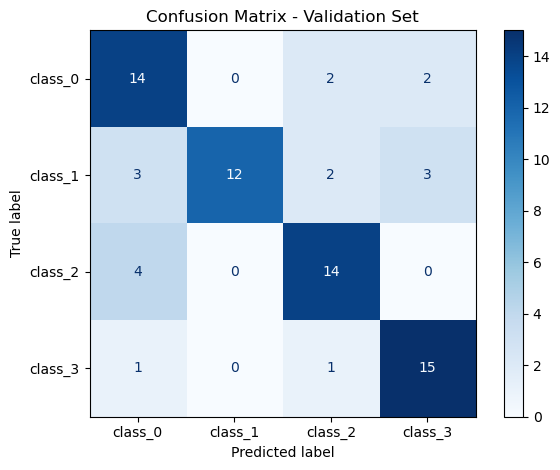

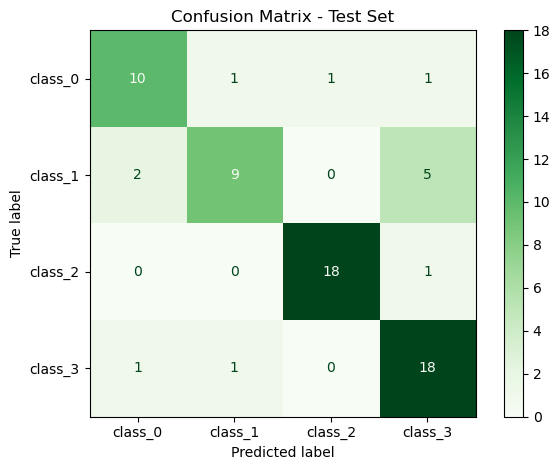

In [56]:
# Determine unique labels for dynamic display
val_labels = sorted(y_val.unique())
test_labels = sorted(y_test.unique())

# Confusion matrix for validation
cm_val = confusion_matrix(y_val, y_val_pred, labels=val_labels)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=[f"class_{i}" for i in val_labels])
disp_val.plot(cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

# Confusion matrix for test
cm_test = confusion_matrix(y_test, y_test_pred, labels=test_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[f"class_{i}" for i in test_labels])
disp_test.plot(cmap='Greens')
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


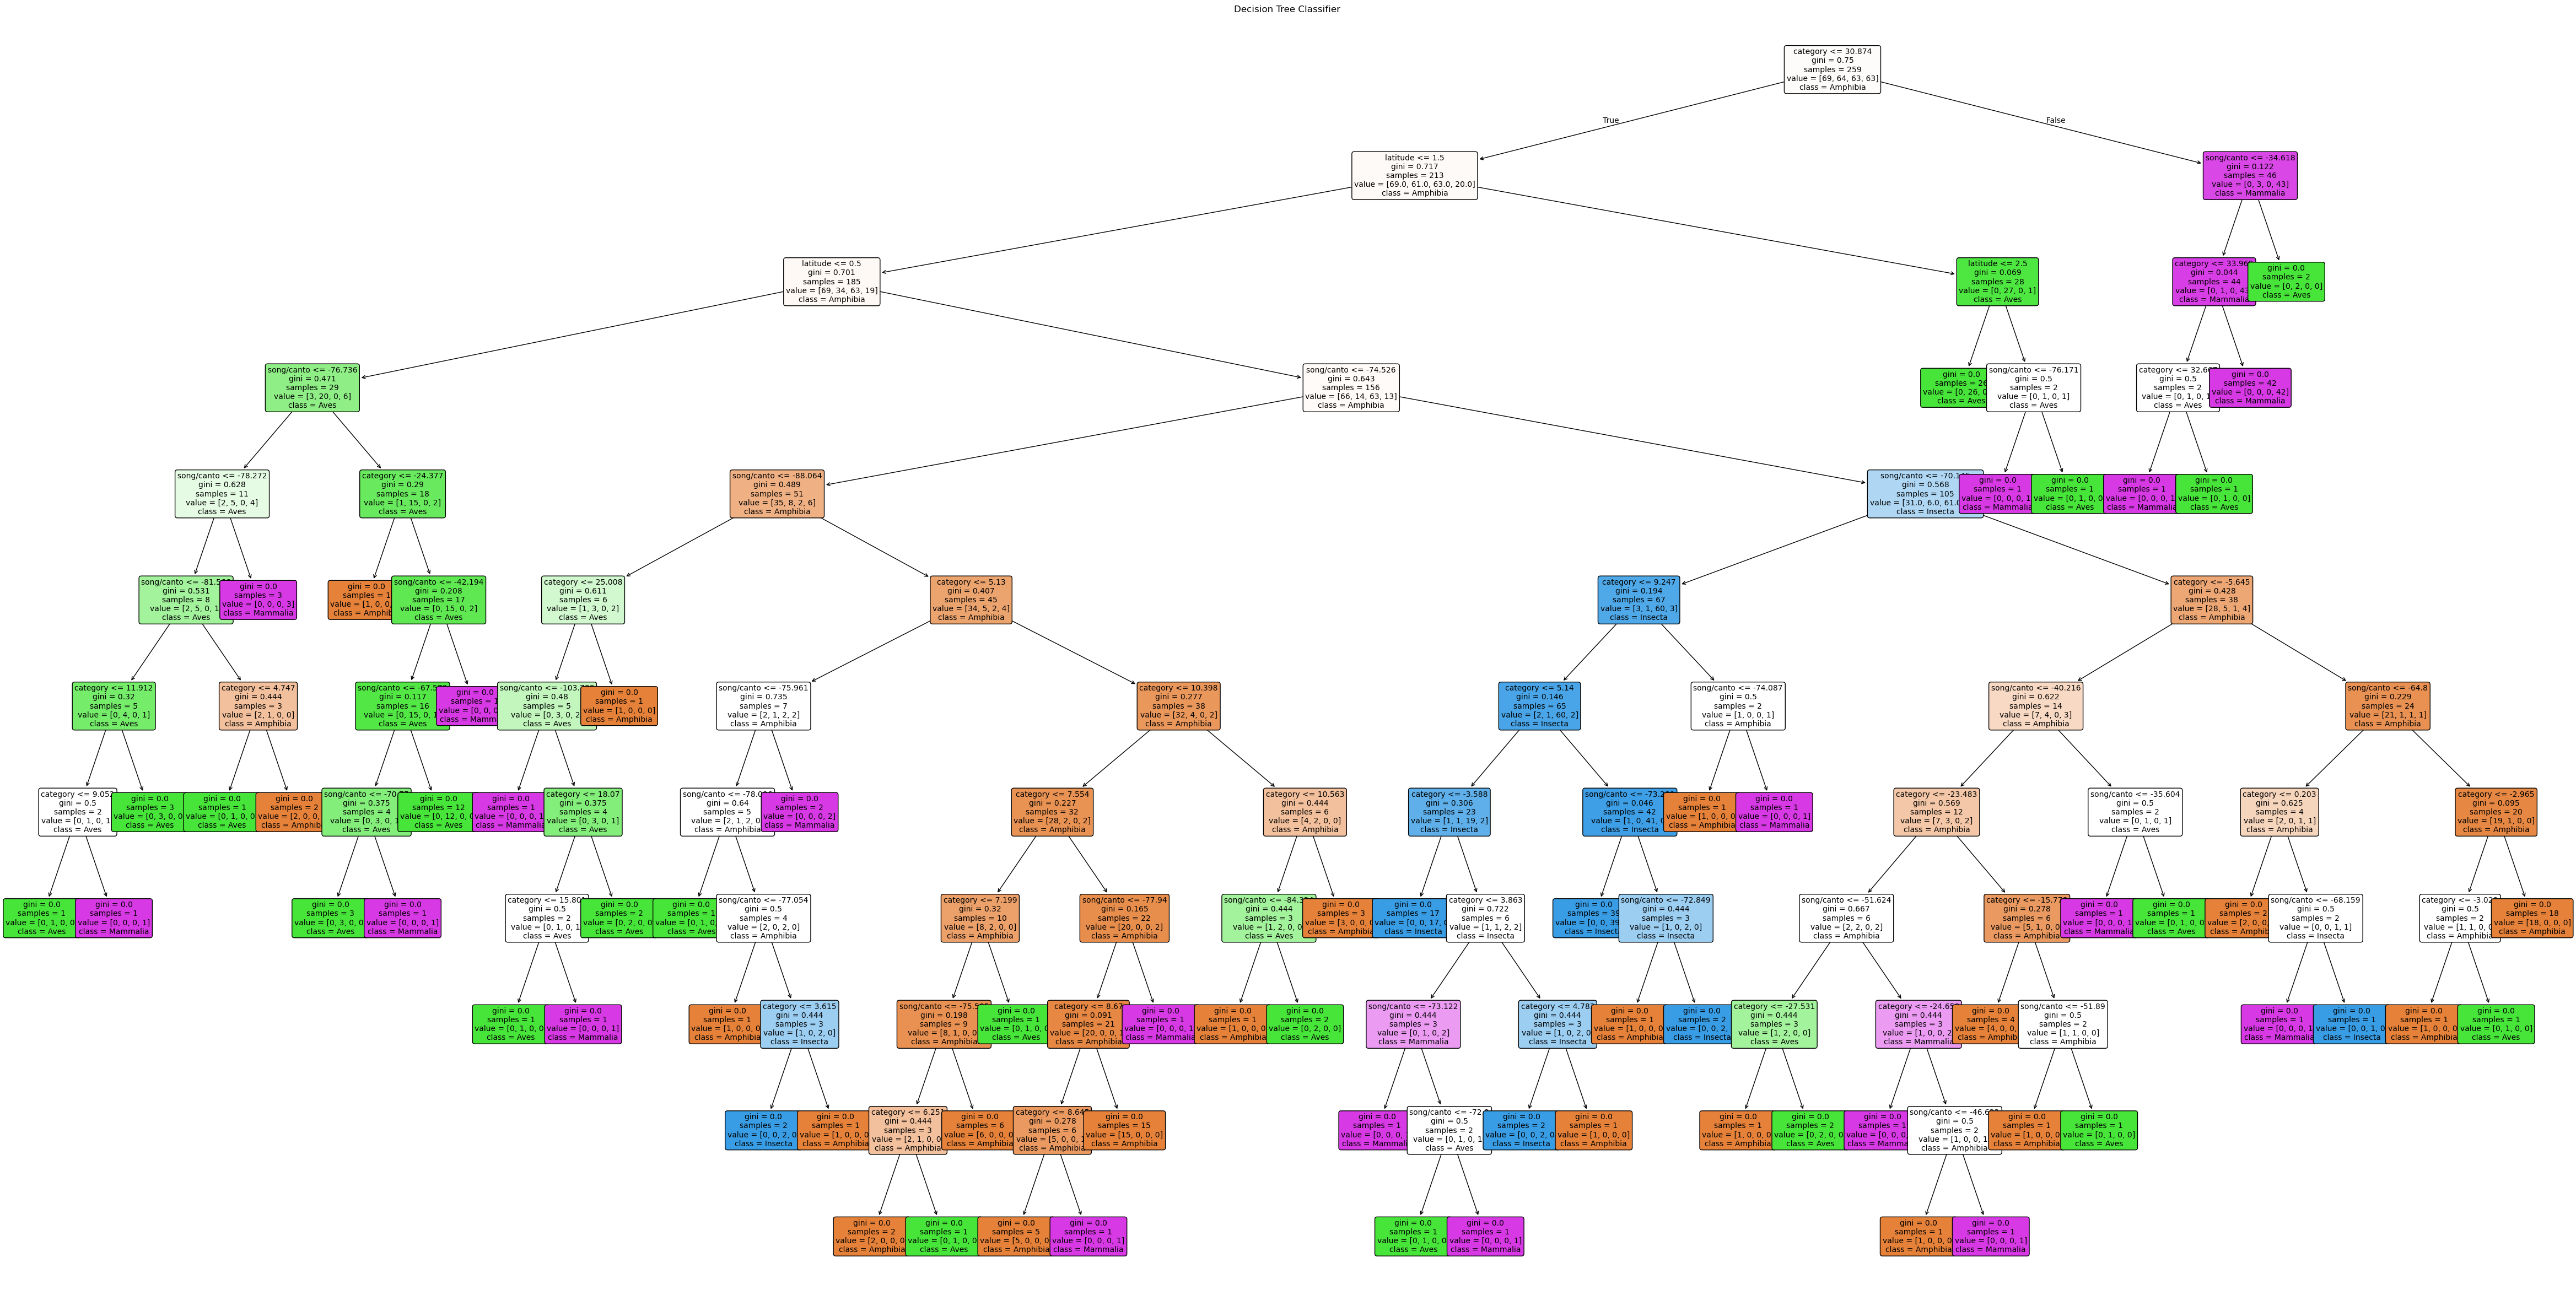

In [55]:
plt.figure(figsize=(60, 30))
plot_tree(
    clf,
    feature_names=list(X.columns),            
    class_names=list(target_encoder.classes_), 
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Classifier")
plt.show()


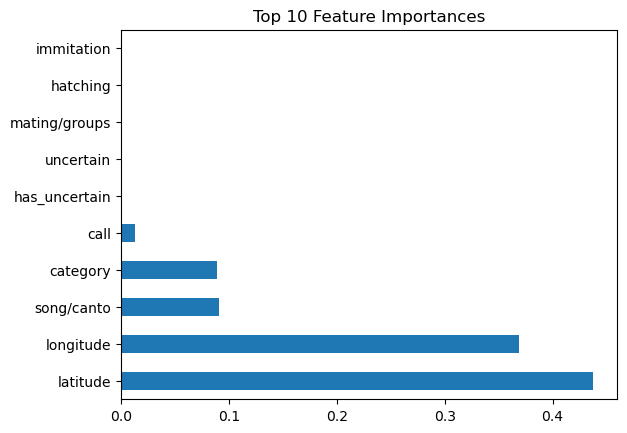

In [26]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

In [ ]:
sound_important_features=sound_weighted[['call','category','song/canto','latitude','longitude','class_name']]

In [ ]:
# Encode target
target_encoder = LabelEncoder()
sound_important_features['class_name_encoded'] = target_encoder.fit_transform(sound_important_features['class_name'])

# Encode features
feature_df = sound_important_features.drop(columns=['class_name', 'class_name_encoded'])
for col in feature_df.select_dtypes(include='object').columns:
    feature_df[col] = LabelEncoder().fit_transform(feature_df[col])

X = feature_df
y = sound_important_features['class_name_encoded']

# Split data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
# (0.25 of 0.8 = 0.2, so final split is 60/20/20)

# Train model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate on validation set
y_val_pred = clf.predict(X_val)
print("=== Validation Set Evaluation ===")
print(classification_report(y_val, y_val_pred, target_names=target_encoder.classes_))

# Predict and evaluate on test set
y_test_pred = clf.predict(X_test)
print("=== Test Set Evaluation ===")
print(classification_report(y_test, y_test_pred, target_names=target_encoder.classes_))


In [ ]:
plt.figure(figsize=(50, 30))
plot_tree(
    clf,
    feature_names=list(X.columns),            
    class_names=list(target_encoder.classes_), 
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Classifier")
plt.show()


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf':[1, 5,10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=3, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
clf = grid.best_estimator_


In [ ]:
clf.fit(X_train, y_train)

# Predict and evaluate on validation set
y_val_pred = clf.predict(X_val)
print("=== Validation Set Evaluation ===")
print(classification_report(y_val, y_val_pred, target_names=target_encoder.classes_))

# Predict and evaluate on test set
y_test_pred = clf.predict(X_test)
print("=== Test Set Evaluation ===")
print(classification_report(y_test, y_test_pred, target_names=target_encoder.classes_))

#### PCA

In [ ]:
class_names = {0: 'Amphibia' , 1: 'Aves', 2: 'Insecta', 3: 'Mammalia'}

In [ ]:
# PCA to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Plot: one color per class
plt.figure(figsize=(8, 6))
for class_index in np.unique(y_train):
    idx = y_train == class_index
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=class_names[class_index], alpha=0.6)

plt.title("PCA of Image Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pca = PCA(n_components=10)
pca.fit(X_train)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Find the first index where cumulative variance > 0.9
n_components_90 = np.argmax(cumulative_var >= 0.9) + 1

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='s', label='Cumulative Explained Variance')

# Add vertical line where cumulative > 0.9
plt.axvline(x=n_components_90, color='red', linestyle='--', label=f'90% Variance at {n_components_90} PCs')
plt.axhline(y=0.9, color='gray', linestyle='--', alpha=0.6)

# Annotate
plt.text(n_components_90 + 1, 0.1, f"{n_components_90} components", color='red')

plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()  # remove classification head
resnet.eval()

# preprocess images and extract features
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # if input is grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

features = []
with torch.no_grad():
    for img in X_train:
        img_tensor = transform(img).unsqueeze(0) 
        feat = resnet(img_tensor).squeeze().numpy()
        features.append(feat)

features = np.stack(features)


##### 2D PCA

In [ ]:
n_components = 2 
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(features)

# Encode labels for coloring
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

# Scatter plot
plt.figure(figsize=(8, 6))
for class_index in np.unique(y_encoded):
    idx = y_encoded == class_index
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=class_names[class_index], alpha=0.6)

plt.title("PCA of ResNet Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pca = PCA(n_components=100)  
pca.fit(features)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Find the first index where cumulative variance > 0.9
n_components_90 = np.argmax(cumulative_var >= 0.9) + 1

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o', label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='s', label='Cumulative Explained Variance')

# Add vertical line where cumulative > 0.9
plt.axvline(x=n_components_90, color='red', linestyle='--', label=f'90% Variance at {n_components_90} PCs')
plt.axhline(y=0.9, color='gray', linestyle='--', alpha=0.6)

# Annotate
plt.text(n_components_90 + 1, 0.1, f"{n_components_90} components", color='red')

plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### SOM

In [ ]:
label_names = {0:'Amphibia',1:'Aves', 2:'Insecta', 3:'Mammalia'}

In [ ]:
som = MiniSom(20, 20, X_train.shape[1], sigma=5, learning_rate=0.5, neighborhood_function='gaussian')
som.train(X_train, 1000)

In [ ]:
w_x, w_y = zip(*[som.winner(d) for d in X_train])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(y_train):
    idx_target = y_train==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
from collections import Counter

# Get BMU (Best Matching Unit) coordinates for each input
winners = [som.winner(d) for d in X_train]
w_x, w_y = zip(*winners)
w_x = np.array(w_x)
w_y = np.array(w_y)

# SOM grid shape
som_shape = som.get_weights().shape[:2]

# Initialize grid for storing the majority label index
label_grid = -np.ones(som_shape, dtype=int)  # -1 = no hits

# Map each cell to its label using majority vote
for i in range(som_shape[0]):
    for j in range(som_shape[1]):
        # Find indices where BMU is (i,j)
        indices = [(wx, wy, label) for wx, wy, label in zip(w_x, w_y, y_train) if wx == i and wy == j]
        if indices:
            labels = [label for _, _, label in indices]
            majority_label = Counter(labels).most_common(1)[0][0]
            label_grid[i, j] = majority_label

# Create a colormap based on the label_names dictionary
label_names = {0: 'Amphibia', 1: 'Amphibia', 2: 'Insecta', 3: 'Mammalia'}
class_ids = sorted(set(label_names.keys()))
cmap = plt.get_cmap('Set2', len(class_ids))  # Discrete colormap

# Plot
plt.figure(figsize=(10, 9))
im = plt.imshow(label_grid.T, cmap=cmap, origin='lower', vmin=0, vmax=len(class_ids)-1)

# Create legend
cbar = plt.colorbar(im, ticks=range(len(class_ids)))
cbar.ax.set_yticklabels([label_names[i] for i in class_ids])
plt.title('SOM Grid Colored by Majority Class')
plt.grid(False)
plt.show()


In [ ]:
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [ ]:
print(classification_report(y_test, classify(som, X_test)))

#### k-NN

In [ ]:
def apply_rope(X):
    X_out = []
    for row in range(len(X)):
        x = torch.tensor(X[row], dtype=torch.float)  # shape (256, 256)
        seq_len, model_dim = x.shape  # both 256

        num_heads = 4
        head_dim = model_dim // num_heads  # 64

        # Reshape to (seq_len, batch, num_heads, head_dim)
        x = x.view(seq_len, 1, num_heads, head_dim)  # (256, 1, 4, 64)

        rotary_pe = RotaryPositionalEmbeddings(64)
        x_rot= rotary_pe(x)
        x_out = x_rot.view(seq_len, -1)  # (256, 256)
        X_out.append(x_out)
    
    return X_out


In [ ]:
def prepare_data(X, y, normalize=True, apply_pca=True, n_components=85):
    if normalize:
        # scaler = StandardScaler()
        scaler= MinMaxScaler()
        X = scaler.fit_transform(X)

    if apply_pca:
        pca = PCA(n_components=n_components)
        X = pca.fit_transform(X)

    return X, y

In [ ]:
def run_knn(X_train, y_train, X_val, y_val, k=3, test_size=0.2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"k-NN accuracy (k={k}): {acc:.4f}")

    return knn, acc


In [ ]:
def plot_knn_accuracy_vs_k(X_train, y_train, X_val, y_val, k_range=range(1, 21)):
    accuracies = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)

    plt.figure(figsize=(8, 5))
    plt.plot(k_range, accuracies, marker='o')
    plt.xticks(k_range)
    plt.xlabel("k (Number of Neighbors)")
    plt.ylabel("Accuracy")
    plt.title("k-NN Accuracy vs. k")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
plot_knn_accuracy_vs_k(X_train, y_train, X_val, y_val)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
plot_confusion_matrix(y_test, y_pred, labels=np.unique(y_test))